In [343]:
import pandas as pd
import numpy as np
import os
import time
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import load_npz
from tqdm import tqdm
import matplotlib.pyplot as plt

In [318]:
user_movie_matrix = pd.read_csv(os.path.join("..","output","collbarfilter.csv"))
user_similarity = pd.read_csv(os.path.join("..","output","UtU_similarityMatrix_demeaned.csv")).iloc[:,1:]
movies = pd.read_csv(os.path.join("..","data","movies.csv"))
ratings = pd.read_csv(os.path.join("..","data","ratings.csv"))

movies["clean_title"] = movies["title"].apply(clean_title)

In [319]:
user_similarity

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.000000,0.0,0.646640,0.834234,0.681039,0.753044,0.849191,0.000000,0.000000,...,0.965906,0.778368,0.573794,0.677603,0.566450,0.804132,0.762377,0.623949,0.000000,0.887288
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.882306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.936433
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.646640,0.000000,0.0,0.000000,0.487821,0.419289,0.703566,0.000000,0.000000,0.000000,...,0.323648,0.576754,0.542102,0.000000,0.744387,0.614767,0.545872,0.214437,0.000000,0.576111
4,0.834234,0.000000,0.0,0.487821,0.000000,0.581018,0.000000,0.648258,0.000000,0.000000,...,0.000000,0.621886,0.577567,0.630608,0.510846,0.762271,0.693848,0.366439,0.843338,0.729946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.804132,0.000000,0.0,0.614767,0.762271,0.617898,0.595718,0.768863,0.869483,0.235694,...,0.940710,0.644550,0.697699,0.850133,0.714752,0.000000,0.673265,0.642292,0.861029,0.841184
606,0.762377,0.000000,0.0,0.545872,0.693848,0.777778,0.828107,0.789352,0.000000,0.000000,...,0.972955,0.745353,0.553022,0.712725,0.555971,0.673265,0.000000,0.630904,0.821995,0.776361
607,0.623949,0.000000,0.0,0.214437,0.366439,0.222823,0.520582,0.650000,0.639608,0.055859,...,0.876135,0.566928,0.453025,0.276873,0.419544,0.642292,0.630904,0.000000,0.664130,0.728631
608,0.000000,0.000000,0.0,0.000000,0.843338,0.743048,0.000000,0.747515,0.000000,0.000000,...,0.000000,0.740203,0.541614,0.910840,0.000000,0.861029,0.821995,0.664130,0.000000,0.721986


In [320]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(movies["clean_title"])

def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = movies.iloc[indices].iloc[::-1]
    

In [321]:
userids = ratings["userId"].unique()
user_similarity.columns = userids
user_similarity.index = userids
user_similarity

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,0.000000,0.000000,0.0,0.646640,0.834234,0.681039,0.753044,0.849191,0.000000,0.000000,...,0.965906,0.778368,0.573794,0.677603,0.566450,0.804132,0.762377,0.623949,0.000000,0.887288
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.882306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.936433
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.646640,0.000000,0.0,0.000000,0.487821,0.419289,0.703566,0.000000,0.000000,0.000000,...,0.323648,0.576754,0.542102,0.000000,0.744387,0.614767,0.545872,0.214437,0.000000,0.576111
5,0.834234,0.000000,0.0,0.487821,0.000000,0.581018,0.000000,0.648258,0.000000,0.000000,...,0.000000,0.621886,0.577567,0.630608,0.510846,0.762271,0.693848,0.366439,0.843338,0.729946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.804132,0.000000,0.0,0.614767,0.762271,0.617898,0.595718,0.768863,0.869483,0.235694,...,0.940710,0.644550,0.697699,0.850133,0.714752,0.000000,0.673265,0.642292,0.861029,0.841184
607,0.762377,0.000000,0.0,0.545872,0.693848,0.777778,0.828107,0.789352,0.000000,0.000000,...,0.972955,0.745353,0.553022,0.712725,0.555971,0.673265,0.000000,0.630904,0.821995,0.776361
608,0.623949,0.000000,0.0,0.214437,0.366439,0.222823,0.520582,0.650000,0.639608,0.055859,...,0.876135,0.566928,0.453025,0.276873,0.419544,0.642292,0.630904,0.000000,0.664130,0.728631
609,0.000000,0.000000,0.0,0.000000,0.843338,0.743048,0.000000,0.747515,0.000000,0.000000,...,0.000000,0.740203,0.541614,0.910840,0.000000,0.861029,0.821995,0.664130,0.000000,0.721986


In [322]:
def clean_title(title):
    return re.sub("[^a-zA-Z0-9 ]","", title)

In [323]:
def personRating(user1, user2):
    return user_similarity.loc[user1, user2]

def movieSimilarity(movie_id, user_id):    
    usersSeen= ratings.loc[ratings["movieId"] == movie_id, ["userId", "rating"]]
    
    if usersSeen.shape[0] < 5:
        return
    
    if usersSeen["userId"].isin([user_id]).any():
        print(f"User {user_id} has already seen movie {movie_id}")
        return
    
    similarityScores = []

    
    for user in usersSeen["userId"]:
        similarityScores.append(personRating(user_id, user))
    
    total_similarity = np.sum(similarityScores)
    
    if total_similarity == 0:
        return
    
    predicted_score = np.dot(usersSeen["rating"], similarityScores)/total_similarity

    
    return predicted_score

In [324]:
class recommendation():
    def __init__(self, SimilarityMatrix, ratings, movies) -> None:
        self.SimilarityMatrix = SimilarityMatrix
        self.ratings = ratings
        self.user = None
        self.movie_id = None
        self.movie_title = None
        self.relevantUsers = None
    
    def run(self, user_id):
        self.user = user_id
        movie_recs = {}
        
        unseen_movies = set(self.ratings["userId"].unique()) - set(self.ratings[ratings["userId"] == self.user]["movieId"])
        for movie in unseen_movies:
            score = movieSimilarity(movie, self.user)
            if score is None or score < 4:
                continue
            movie_recs[movie] = score
        
        movie_recs_pd = pd.DataFrame.from_dict(movie_recs, orient = "index", columns = ["predictedRating"])
        movie_recs_pd = movie_recs_pd.reset_index().rename(columns={'index': 'movieId'})
        movie_recs_pd['movieId'] = movie_recs_pd['movieId'].astype(movies['movieId'].dtype)

        merged_df = pd.merge(movies, movie_recs_pd, on='movieId', how='right')

        return merged_df.sort_values("predictedRating", ascending=False)

In [325]:
recs = recommendation(SimilarityMatrix= user_similarity, ratings = ratings, movies = movies)
movie_recs = recs.run(user_id=300)

In [326]:
movie_recs

,movieId,title,genres,clean_title,predictedRating
22,334,Vanya on 42nd Street (1994),Drama,Vanya on 42nd Street 1994,5.000000
12,213,Burnt by the Sun (Utomlyonnye solntsem) (1994),Drama,Burnt by the Sun Utomlyonnye solntsem 1994,4.500000
17,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,Pulp Fiction 1994,4.447291
5,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,Usual Suspects The 1995,4.315682
27,475,In the Name of the Father (1993),Drama,In the Name of the Father 1993,4.265655
19,306,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,Three Colors Red Trois couleurs Rouge 1994,4.257780
28,501,Naked (1993),Drama,Naked 1993,4.250655
13,215,Before Sunrise (1995),Drama|Romance,Before Sunrise 1995,4.246037
20,322,Swimming with Sharks (1995),Comedy|Drama,Swimming with Sharks 1995,4.206408
16,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller,Lon The Professional aka The Professional Lon ...,4.202012


In [327]:
import ipywidgets as widgets
from IPython.display import display

recs = recommendation(SimilarityMatrix= user_similarity, ratings = ratings, movies = movies)

userid_input = widgets.Text(
    value="",
    description='User Id:',
    disabled=False
)
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        id = data["new"]
        display(recs.run(user_id=int(id)))

userid_input.observe(on_type, names='value')

display(userid_input, recommendation_list)

Text(value='', description='User Id:')

Output()

In [336]:
top_recommendations = []

for i in tqdm(range(610)):
    try:
        recommendation = recs.run(i+1)
        # Ensure that the DataFrame is not empty and the column exists
        if recommendation is not None and "movieId" in recommendation:
            top_recommendations.append(recommendation.iloc[0]["movieId"])
        else:
            top_recommendations.append(None)  # or some placeholder for no recommendation
    except Exception as e:
        print(f"An error occurred for user {i+1}: {e}")
        top_recommendations.append(None) 

 29%|██▊       | 175/610 [00:46<01:54,  3.80it/s]

An error occurred for user 175: single positional indexer is out-of-bounds


100%|██████████| 610/610 [02:40<00:00,  3.79it/s]


<Axes: >

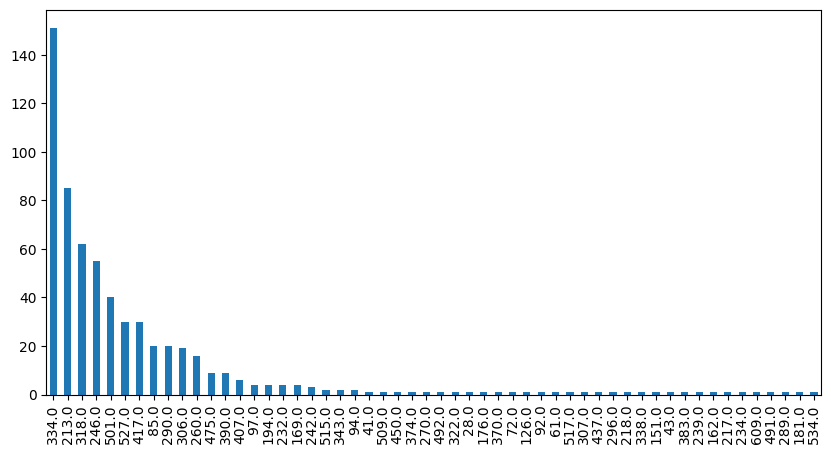

In [348]:
recommend_count = pd.Series(top_recommendations).value_counts()

recommend_count.plot(kind = "bar", figsize=(10, 5))

In [363]:
recommended = pd.DataFrame(recommend_count).merge(movies, left_index= True, right_on = "movieId", how = "left")

<BarContainer object of 54 artists>

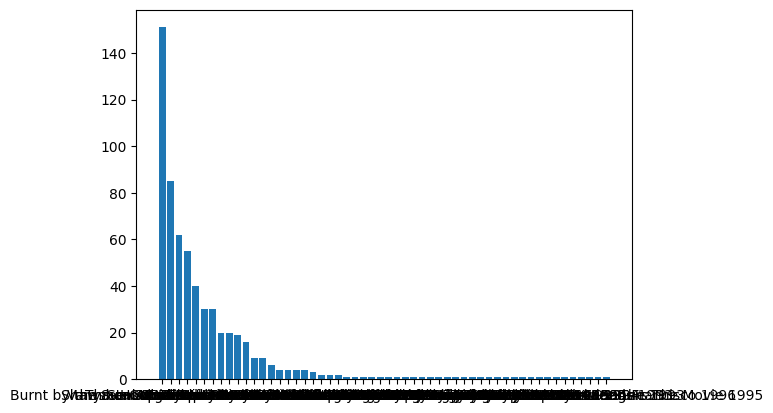

In [364]:
plt.bar(x = recommended["clean_title"], height = recommended["count"])
plt.xticks(rotation=45)

# Set the x-axis label
plt.xlabel('Movie Titles')

# Set the y-axis label
plt.ylabel('Count')

# Optional: Add a title to the plot
plt.title('Recommendation Counts')
